<a href="https://colab.research.google.com/github/Shakhawat-Fahim/EmpathyWithRoberta/blob/main/empathy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# uploaded = files.upload()  # Upload your NewsEssay v4 CSV file


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV (replace with your filename if different)
f = "trac3_EMP_train.csv"
df = pd.read_csv(f,  escapechar='\\')
# df = pd.read_csv("trac3_EMP_train.csv")

# Show a few examples
df[['person_essay', 'person_empathy', 'person_distress']].head()


,person_essay,person_empathy,person_distress
0,How sad is it that this kind of pain and suffe...,3.857143,3.285714
1,It breaks my heart to see people living in tho...,6.714286,6.714286
2,I wonder why there aren't more people trying t...,5.857143,6.000000
3,The article is kind of tragic and hits close t...,2.714286,1.000000
4,"After reading the article, you can't help but ...",1.000000,1.428571


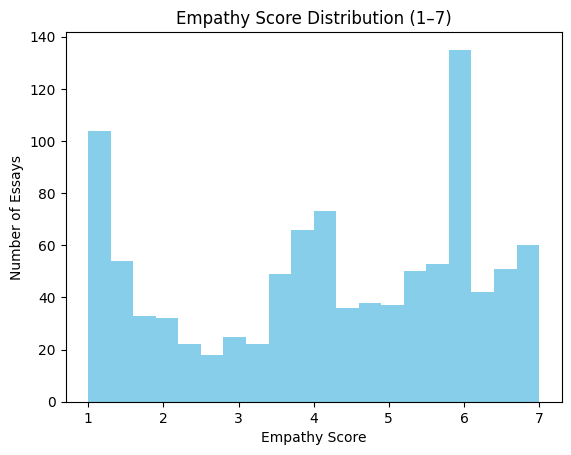

In [ ]:
plt.hist(df['person_empathy'], bins=20, color='skyblue')
plt.title("Empathy Score Distribution (1–7)")
plt.xlabel("Empathy Score")
plt.ylabel("Number of Essays")
plt.show()


In [ ]:
# ✅ STEP 2: Fine-tune RoBERTa to Predict Empathy Score (Regression Task)
!pip install -q transformers datasets scikit-learn evaluate


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import evaluate

# 📁 Load your dataset (you must upload it first via Colab UI)
# df = pd.read_csv("NewsEssayV4.csv")

# 🧹 Keep only needed columns
df = df[['person_essay', 'person_empathy']].dropna()
df = df.rename(columns={'person_essay': 'text', 'person_empathy': 'label'})

# 🪄 Normalize labels between 0 and 1 (optional but helps training)
df['label'] = df['label'] / 7.0

# ✂️ Train/Validation Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)


In [ ]:
# 🔤 Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1)

def tokenize(example):
    return tokenizer(example["text"], truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# ⚙️ Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
)

# 📏 Metric
metric = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    return metric.compute(predictions=predictions, references=labels)

# 🧠 Trainer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-24-2139584519.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 🚀 Train!
trainer.train()

# 💾 Save model
model.save_pretrained("empathy-roberta-model")
tokenizer.save_pretrained("empathy-roberta-model")

print("\n✅ Training complete. Model saved to 'empathy-roberta-model'")


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sakhawat-fahim-bd (sakhawat-fahim-bd-therap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Pearsonr
1,No log,0.066251,0.521163
2,No log,0.048018,0.648872
3,No log,0.047415,0.672584



✅ Training complete. Model saved to 'empathy-roberta-model'
